In [1]:
import sim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Check if python is connecting to Coppelia

In [2]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Omnirob'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')


Connected
Simulation time in milliseconds:  49250
Omnirob is at [x,y,z]= [7.624996185302734, 8.54612922668457, 0.3544992208480835]
Disconnected


# Robot

In [3]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

# Grid

In [4]:
n, m = 20,20  # number of rows and columns respectively.

obstacles = [[2.725, -0.00000027, 4, 1, -40],
             [7.425, 4.725, 4, 1, 0],
             [-1.025, -1.5, 4, 1, 0],
             [-6.7, 6.4, 4, 1, 0],
             [-5.15, -6.2, 4, 1, 150],
             [2.425, 4.075, 1, 1, 0],
             [4.4, 0.875, 1, 1, 0],
             [2.825, -4.85, 1, 1, 0],
             [-0.525, 6.3, 1, 1, 0],
             [-5.125, 3.425, 1, 1, 0],
             [-1.775, 2.1, 1, 1, 0],
             [-5.8, -0.975, 1, 1, 0],
             [7.275, -7.75, 1, 1, 0]
              ]

In [5]:
# Create a matrix to represent the cells of the grid
grid = np.zeros((n, m))

for obs in obstacles:
    if not obs[4]:
        for i in range(math.floor(obs[0] - (obs[2]+1)/2)+10, math.ceil(obs[0] + (obs[2]+1)/2)+10, 1):
            for j in range(math.floor(obs[1] - (obs[3]+1)/2)+10, math.ceil(obs[1] + (obs[3]+1)/2)+10, 1):
                grid[j][i] = 1
    else:
        diag = sqrt(square(obs[2]+1) + square(obs[3]+1))
        for i in range(math.floor(obs[0] - diag/2)+10, math.ceil(obs[0] + diag/2)+10, 1):
            for j in range(math.floor(obs[1] - diag/2)+10, math.ceil(obs[1] + diag/2)+10, 1):
                grid[j][i] = 1
                
grid[1][2] = 0
grid[1][3] = 0
grid[1][4] = 0
grid[1][5] = 0
grid[2][2] = 0
grid[2][3] = 0
grid[12][15] = 0
grid[12][14] = 0
grid[12][13] = 0
grid[4][7] = 0
grid[5][7] = 0
grid[6][2] = 0
grid[6][3] = 0
grid[6][4] = 0
grid[6][5] = 0
grid[6][6] = 0
grid[6][7] = 0
grid[5][5] = 0
grid[5][6] = 0

# Plot

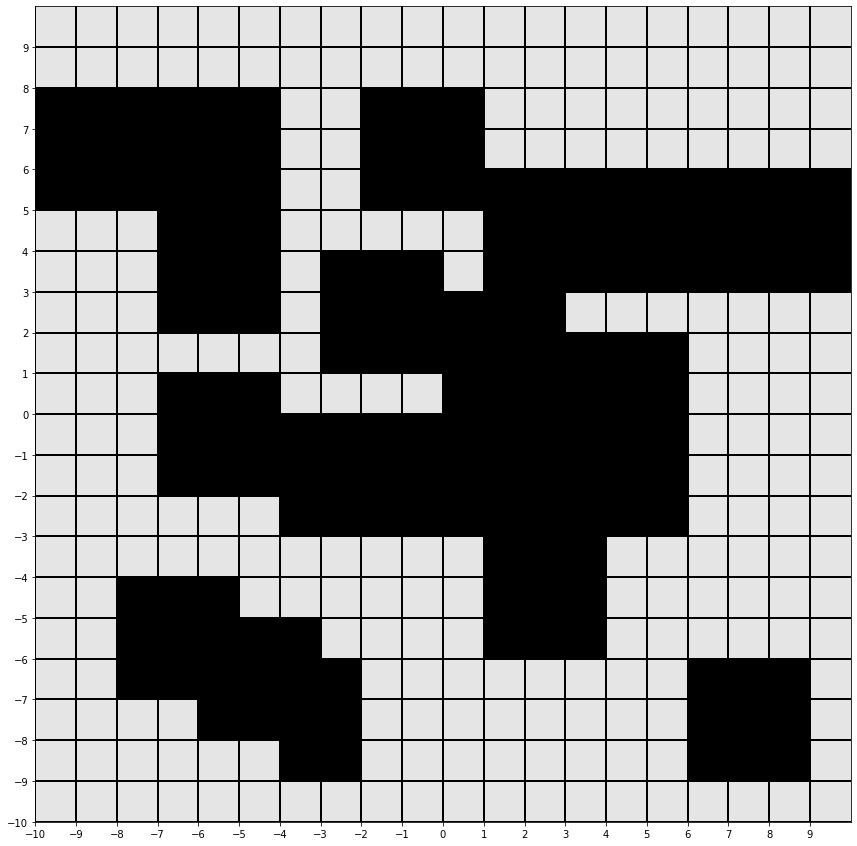

In [6]:
from matplotlib import colors
# Plot the grid
def draw_grid():
    fig, ax = plt.subplots(figsize=(15,15))
    cmap = colors.ListedColormap(['0.9', 'black']) # Colors (0.9 is the almost white in gray scale)
    ax.imshow(grid, cmap=cmap, origin='lower', extent=[-10,10,-10,10])
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-m/2, m/2, 1));
    ax.set_yticks(np.arange(-n/2, n/2, 1));

draw_grid()

In [7]:
import networkx as nx
# This function automatically creates the graph in a grid.
G = nx.grid_2d_graph(n, m) 
print("Number of nodes in a full grid (n*m): ",len(G.nodes()))
# Delete nodes with obstacles
for i in range(n):
    for j in range(m):
        # if the node is an obstacle
        if grid[i][j] == 1:  
            G.remove_node((i,j))

Number of nodes in a full grid (n*m):  400


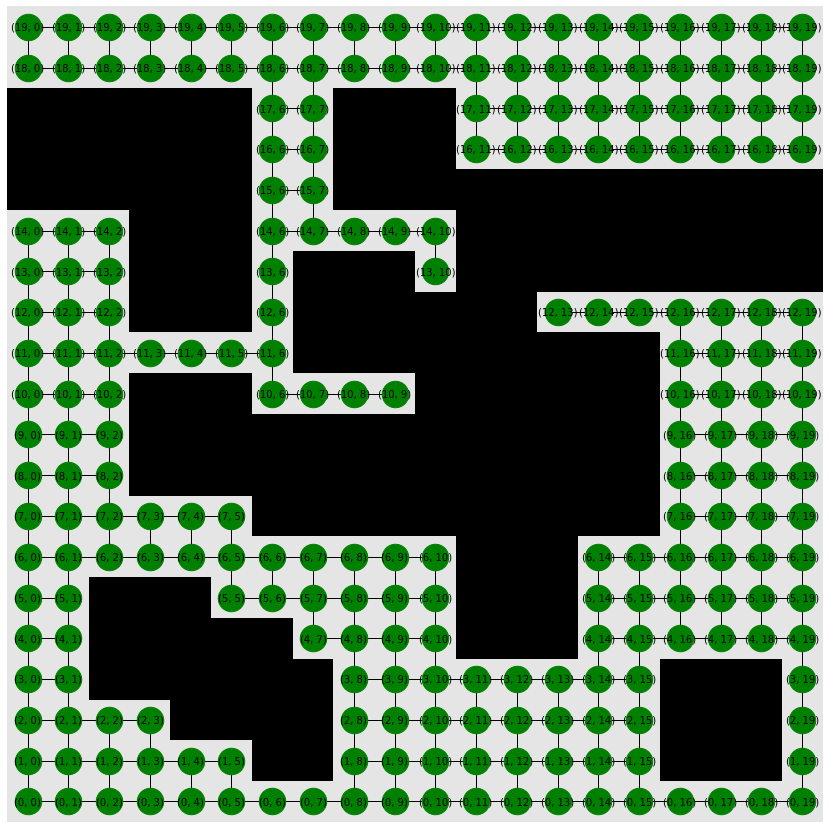

In [8]:
# Plot grid
def overlap_grid():
    fig, ax = plt.subplots(figsize=(15,15))
    cmap = colors.ListedColormap(['0.9', 'black']) # Colors (0.9 is the almost white in gray scale)
    ax.imshow(grid, cmap=cmap, origin='lower')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, m, 1));
    ax.set_yticks(np.arange(-0.5, n, 1));
overlap_grid()

# Plot the graph
pos = {node:(node[1], node[0]) for node in G.nodes()}  # by making (x,y) = j, -i, where i and j iterate over the columns and the rows respectively.
nx.draw(G, pos, font_size=10, with_labels=True, node_size=700, node_color="g")

In [9]:
start_node = (18, 17)
end_node = (2, 2)

# Run BFS to generate a tree
bfs_tree = nx.bfs_tree(G, source=start_node)
bfs_tree


In [10]:
# Pick the last element and iterate through its predecessors
path = [end_node]   # A path in a graph is a set of connected nodes
current = end_node

# iterate through its predecessors until finding source node
while current != start_node:
    # Predecesors of the current node        
    for pre in bfs_tree.predecessors(current):
        current = pre
    # add the predecessor to the path
    path.append(pre)
        
# The current path starts in the goal node and ends at the start node. So we invert it
path = path[::-1]

# Correct path
print(path)

[(18, 17), (18, 16), (18, 15), (18, 14), (18, 13), (18, 12), (18, 11), (18, 10), (18, 9), (18, 8), (18, 7), (17, 7), (16, 7), (15, 7), (14, 7), (14, 6), (13, 6), (12, 6), (11, 6), (11, 5), (11, 4), (11, 3), (11, 2), (10, 2), (9, 2), (8, 2), (7, 2), (6, 2), (6, 1), (5, 1), (4, 1), (3, 1), (2, 1), (2, 2)]


[(18, 17), (18, 16), (18, 15), (18, 14), (18, 13), (18, 12), (18, 11), (18, 10), (18, 9), (18, 8), (18, 7), (17, 7), (16, 7), (15, 7), (14, 7), (14, 6), (13, 6), (12, 6), (11, 6), (11, 5), (11, 4), (11, 3), (11, 2), (10, 2), (9, 2), (8, 2), (7, 2), (6, 2), (6, 1), (5, 1), (4, 1), (3, 1), (2, 1), (2, 2)]


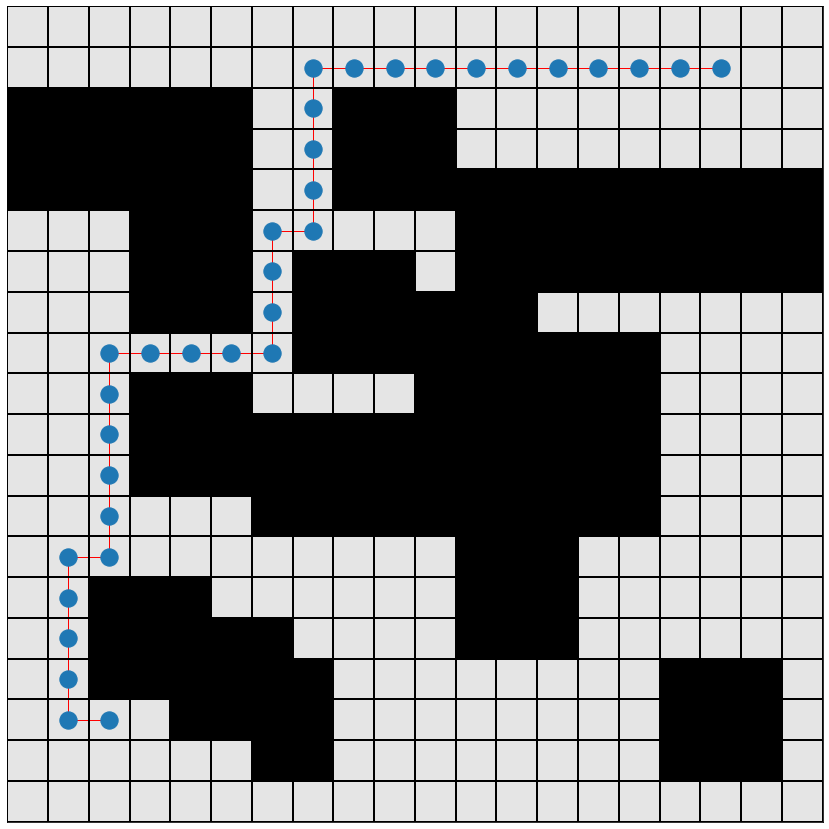

In [11]:
# Edges of the path
E = [(path[i], path[i+1])for i in range(len(path)-1)]

overlap_grid()
nx.draw_networkx_nodes(path, pos)
nx.draw_networkx_edges(G, edgelist=E, pos=pos,edge_color='r')
print(path)

# Trajectory follower

In [12]:
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

tf = 10
ti = 0.1

for i in range(1, len(path)):
    x = path[i][1] - 10
    y = path[i][0] - 10
    px = path[i-1][1] - 10
    py = path[i-1][0] - 10
    delta_x = x - px
    delta_y = y - py
    for j in range(0 ,tf):
        vel_traj = array([delta_x/tf, delta_y/tf])
        traj_point = array([px + j * delta_x/tf, py + j * delta_y/tf])
        robot_position = r.get_position()
        robot_position = array([robot_position[0], robot_position[1]])
        u = 10*(traj_point - robot_position) + vel_traj
        vx, vy = u
        
        r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
        time.sleep(ti)

r.send_motor_velocities([0, 0, 0, 0])

r.close_connection()  # End

Robot connected
Connection closed
